# Capstone F7 Week 3 - Complete Analysis

## Pure GP with 30% Local Exploitation

**Week 2 Result:** 1.739 (RANK 1 🥇, +27% improvement!)  
**Strategy:** Local exploitation - refine around Week 2's success  
**Approach:** 30% local + 20% boundary + 50% random, xi=0.05

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
function_number = 7
print('='*70)
print('CAPSTONE F7 WEEK 3: PURE GP WITH LOCAL EXPLOITATION')
print('='*70)
print('\nWeek 2: RANK 1 (+27% improvement!)')
print('Strategy: 30% local candidates near Week 2 point')

CAPSTONE F7 WEEK 3: PURE GP WITH LOCAL EXPLOITATION

Week 2: RANK 1 (+27% improvement!)
Strategy: 30% local candidates near Week 2 point


## Load Data

In [21]:
# Load Week 3 data (includes Week 2 result)
X = np.load('F7_W3_inputs.npy')
Y = np.load('F7_W3_outputs.npy')

print(f'Data: {len(X)} samples, {X.shape[1]}D')
print(f'Best: {Y.max():.6f}')
print(f'n/p: {len(X)/X.shape[1]:.2f}')

# Identify Week 2 point (best point)
week2_idx = np.argmax(Y)
week2_point = X[week2_idx]
week2_value = Y[week2_idx]

print(f'\nWeek 2 Point (RANK 1):') 
print(f'  Index: {week2_idx}')
print(f'  Value: {week2_value:.6f}')
print(f'  Point: {week2_point}')

Data: 32 samples, 6D
Best: 1.739248
n/p: 5.33

Week 2 Point (RANK 1):
  Index: 31
  Value: 1.739248
  Point: [0.016201 0.437721 0.301359 0.217887 0.38836  0.697756]


## Train Gaussian Process

In [22]:
# Kernel for 6D
kernel = ConstantKernel(1.0) * Matern(0.3, nu=2.5) + WhiteKernel(1e-10)

gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=50,
    normalize_y=True,
    random_state=42
)

gp.fit(X, Y)

print(f'GP R²: {gp.score(X, Y):.3f}')
print(f'Log marginal likelihood: {gp.log_marginal_likelihood_value_:.2f}')

GP R²: 0.992
Log marginal likelihood: -38.40


## Generate Candidates - LOCAL FOCUS

In [23]:
print('\nGenerating candidates with LOCAL FOCUS...')
np.random.seed(42)

# 1. LOCAL REFINEMENT (30% = 3,000)
print('\n1. LOCAL candidates (30%):')
n_local = 3000
local_std = 0.15

X_local = []
for _ in range(n_local):
    perturbation = np.random.normal(0, local_std, 6)
    candidate = week2_point + perturbation
    candidate = np.clip(candidate, 0, 1)
    X_local.append(candidate)

X_local = np.array(X_local)
distances = np.linalg.norm(X_local - week2_point, axis=1)
print(f'   Generated: {len(X_local):,}')
print(f'   Mean distance from W2: {distances.mean():.3f}')
print(f'   Max distance: {distances.max():.3f}')

# 2. BOUNDARY EXPLORATION (20% = 2,000)
print('\n2. BOUNDARY candidates (20%):')
n_boundary = 2000

X_boundary = []
while len(X_boundary) < n_boundary:
    candidate = np.random.uniform(0, 1, 6)
    if (candidate < 0.1).any() or (candidate > 0.9).any():
        X_boundary.append(candidate)

X_boundary = np.array(X_boundary[:n_boundary])
print(f'   Generated: {len(X_boundary):,}')

# 3. RANDOM GLOBAL (50% = 5,000)
print('\n3. RANDOM global candidates (50%):')
n_random = 5000
X_random = np.random.uniform(0, 1, (n_random, 6))
print(f'   Generated: {len(X_random):,}')

# Combine all
X_filtered = np.vstack([X_local, X_boundary, X_random])
print(f'\nTotal candidates: {len(X_filtered):,}')


Generating candidates with LOCAL FOCUS...

1. LOCAL candidates (30%):
   Generated: 3,000
   Mean distance from W2: 0.331
   Max distance: 0.729

2. BOUNDARY candidates (20%):
   Generated: 2,000

3. RANDOM global candidates (50%):
   Generated: 5,000

Total candidates: 10,000


## GP Optimization

In [24]:
# Expected Improvement function
def expected_improvement(X_new, gp, y_best, xi=0.05):
    """Expected Improvement with REDUCED xi for exploitation."""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-10)
    improvement = mu - y_best - xi
    Z = improvement / sigma
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-10] = 0.0
    return ei

y_best = Y.max()
print(f'Current best: {y_best:.6f}')
print(f'Calculating EI with xi=0.05 (exploitation)...')

# Calculate EI
ei_values = expected_improvement(X_filtered, gp, y_best, xi=0.05)
mu_all, sigma_all = gp.predict(X_filtered, return_std=True)

# Select maximum EI
best_idx = np.argmax(ei_values)
x_next = X_filtered[best_idx]
mu_next = mu_all[best_idx]
sigma_next = sigma_all[best_idx]
ei_next = ei_values[best_idx]

# Determine source
is_local = best_idx < len(X_local)
is_boundary = len(X_local) <= best_idx < (len(X_local) + len(X_boundary))
is_random = best_idx >= (len(X_local) + len(X_boundary))

distance_from_w2 = np.linalg.norm(x_next - week2_point)

print('\n' + '='*70)
print('WEEK 3 RECOMMENDATION')
print('='*70)
print(f'\nPoint: {x_next}')
print(f'\nPredicted: {mu_next:.6f} ± {sigma_next:.6f}')
print(f'EI: {ei_next:.6f}')
print(f'Expected gain: {((mu_next/y_best-1)*100):+.2f}%')

print(f'\nSource:')
if is_local:
    print(f'  ✓ LOCAL refinement set (30%)')
    print(f'  Distance from W2: {distance_from_w2:.3f}')
    print(f'  → GP chose EXPLOITATION!')
elif is_boundary:
    print(f'  BOUNDARY exploration set (20%)')
else:
    print(f'  RANDOM global set (50%)')

print(f'\nDistance from Week 2: {distance_from_w2:.3f}')

Current best: 1.739248
Calculating EI with xi=0.05 (exploitation)...

WEEK 3 RECOMMENDATION

Point: [0.         0.42648036 0.30568633 0.17213981 0.35789019 0.637217  ]

Predicted: 1.543955 ± 0.171854
EI: 0.005932
Expected gain: -11.23%

Source:
  ✓ LOCAL refinement set (30%)
  Distance from W2: 0.084
  → GP chose EXPLOITATION!

Distance from Week 2: 0.084


## ACQUISITION FUNCTION VISUALIZATIONS

Creating acquisition curves for F7...


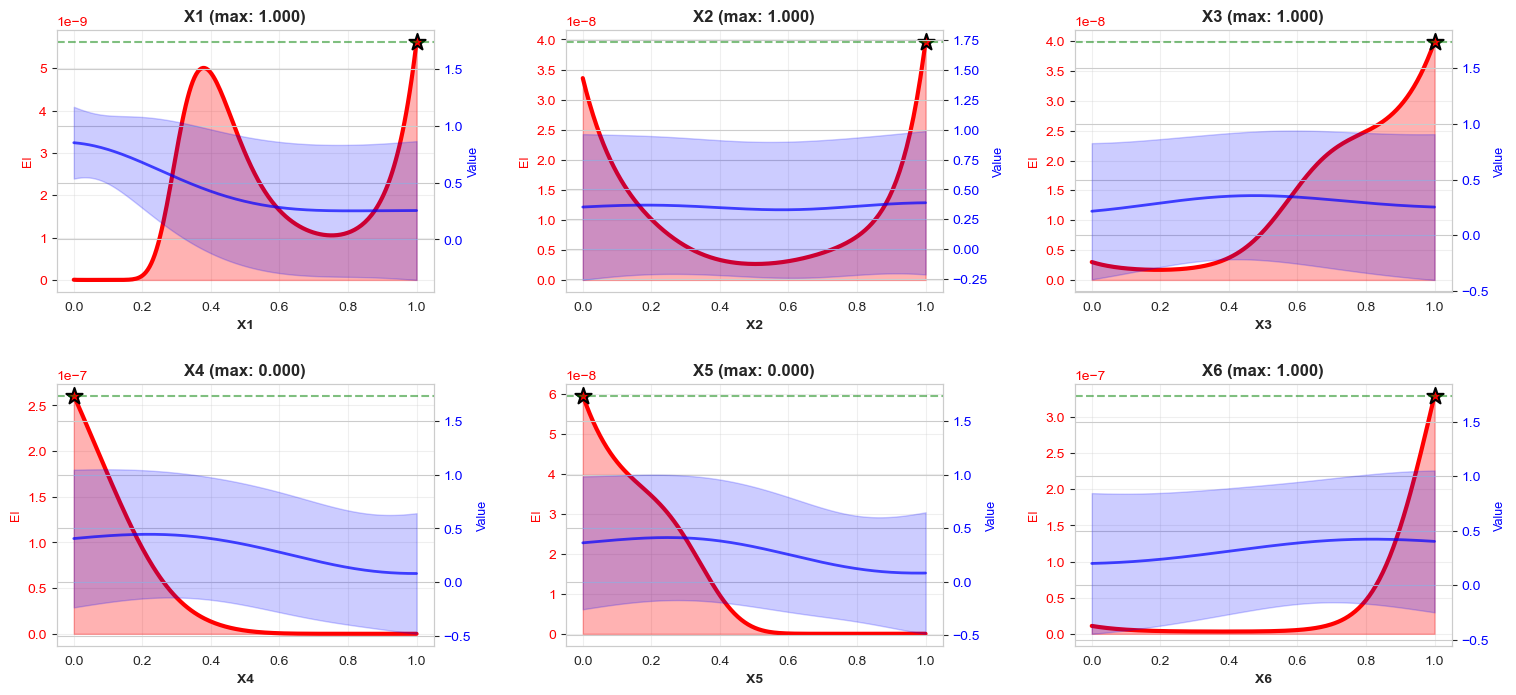

✓ Saved!


In [25]:
print(f'Creating acquisition curves for F{function_number}...')

# Get dimensions from data
n_dims = X.shape[1]

# Calculate grid size
n_cols = 3
n_rows = (n_dims + n_cols - 1) // n_cols  # Ceiling division

fig = plt.figure(figsize=(18, 4 * n_rows))
gs = fig.add_gridspec(n_rows, n_cols, hspace=0.35, wspace=0.35)

for dim in range(n_dims):  # ✅ Correct for any function!
    ax = fig.add_subplot(gs[dim // n_cols, dim % n_cols])
    ax2 = ax.twinx()
    
    x1 = np.linspace(0, 1, 200)
    Xt = np.tile(X.mean(axis=0), (200, 1))
    Xt[:, dim] = x1
    
    m, s = gp.predict(Xt, return_std=True)
    e = expected_improvement(Xt, gp, y_best, 0.1)
    
    # GP plot
    ax2.plot(x1, m, 'b-', lw=2, alpha=0.7)
    ax2.fill_between(x1, m - 2*s, m + 2*s, alpha=0.2, color='blue')
    ax2.axhline(y_best, color='green', ls='--', alpha=0.5)
    ax2.set_ylabel('Value', color='blue', fontsize=9)
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # EI plot
    ax.plot(x1, e, 'r-', lw=3)
    ax.fill_between(x1, 0, e, alpha=0.3, color='red')
    
    mi = np.argmax(e)
    ax.scatter(x1[mi], e[mi], color='red', s=150, marker='*', 
              zorder=5, edgecolors='black', lw=1.5)
    
    ax.set_xlabel(f'X{dim+1}', fontweight='bold')
    ax.set_ylabel('EI', color='red', fontsize=9)
    ax.set_title(f'X{dim+1} (max: {x1[mi]:.3f})', fontweight='bold')
    ax.tick_params(axis='y', labelcolor='red')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'Capstone_F{function_number}_W3_acquisition.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved!')

## Results Visualization

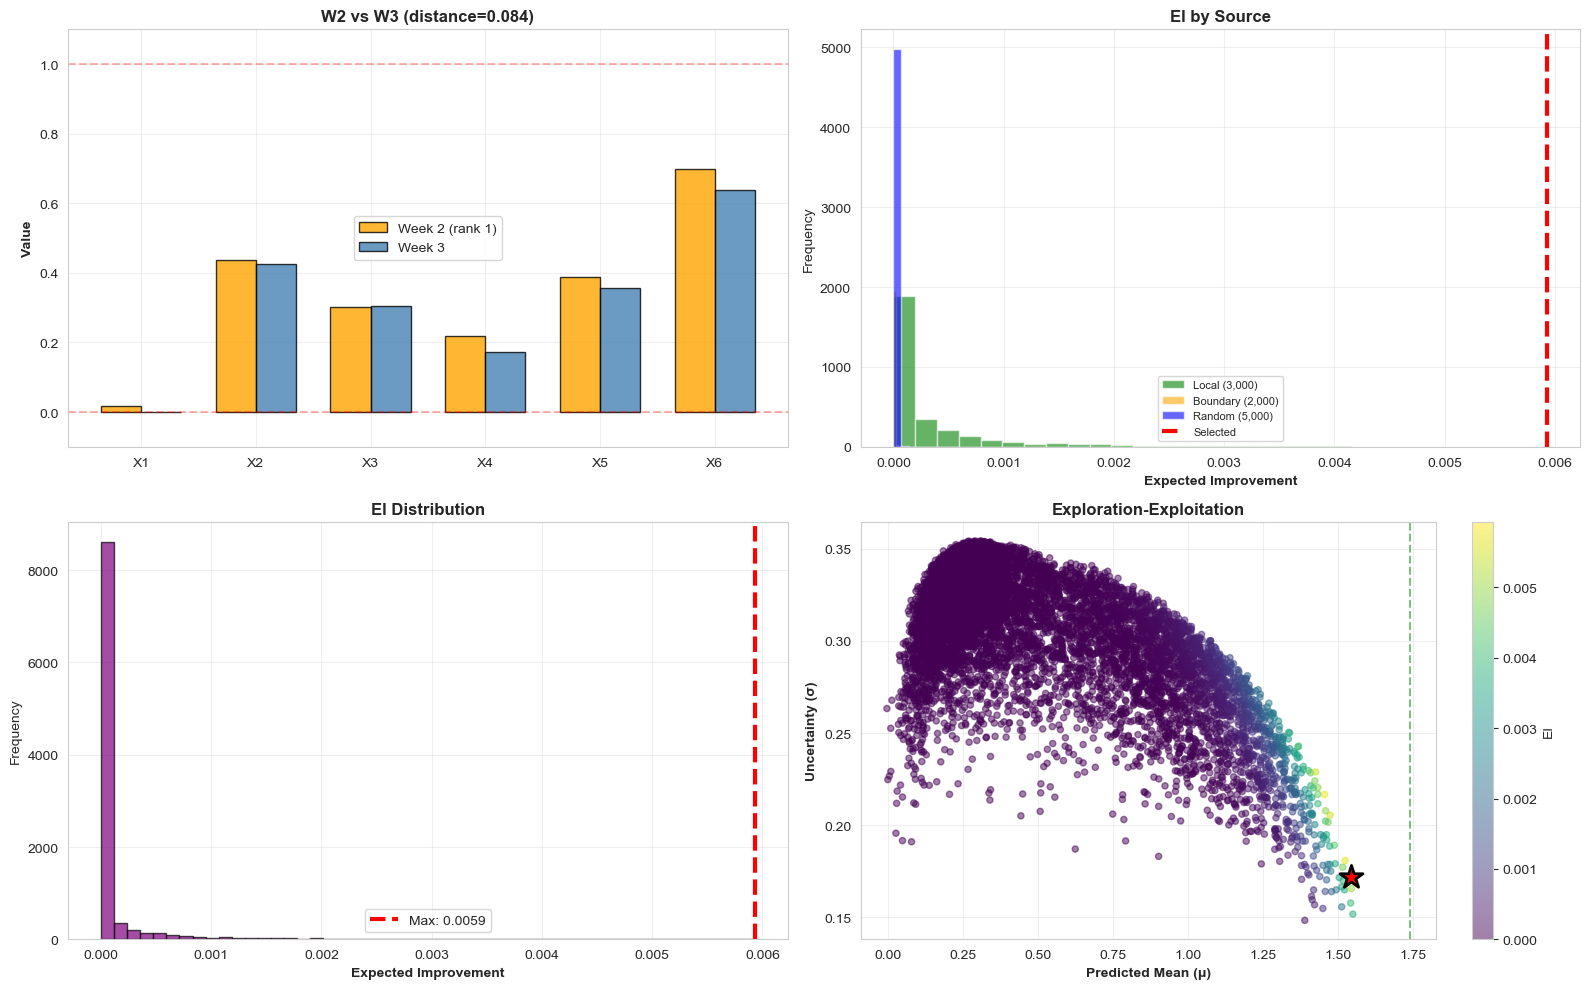

✓ Saved: Capstone_F7_W3_results.png


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

dims = np.arange(6)
width = 0.35

# W2 vs W3 comparison
ax = axes[0, 0]
ax.bar(dims - width/2, week2_point, width, label='Week 2 (rank 1)', 
       alpha=0.8, color='orange', edgecolor='black')
ax.bar(dims + width/2, x_next, width, label='Week 3', 
       alpha=0.8, color='steelblue', edgecolor='black')
ax.axhline(0, color='red', linestyle='--', alpha=0.3)
ax.axhline(1, color='red', linestyle='--', alpha=0.3)
ax.set_xticks(dims)
ax.set_xticklabels([f'X{i+1}' for i in dims])
ax.set_ylabel('Value', fontweight='bold')
ax.set_title(f'W2 vs W3 (distance={distance_from_w2:.3f})', 
            fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(-0.1, 1.1)

# EI by source
ax = axes[0, 1]
ei_local = ei_values[:len(X_local)]
ei_boundary = ei_values[len(X_local):len(X_local)+len(X_boundary)]
ei_random = ei_values[len(X_local)+len(X_boundary):]

ax.hist(ei_local, bins=30, alpha=0.6, label=f'Local ({len(ei_local):,})', color='green')
ax.hist(ei_boundary, bins=30, alpha=0.6, label=f'Boundary ({len(ei_boundary):,})', color='orange')
ax.hist(ei_random, bins=30, alpha=0.6, label=f'Random ({len(ei_random):,})', color='blue')
ax.axvline(ei_next, color='red', linestyle='--', linewidth=3, label=f'Selected')
ax.set_xlabel('Expected Improvement', fontweight='bold')
ax.set_ylabel('Frequency')
ax.set_title('EI by Source', fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# EI distribution
ax = axes[1, 0]
ax.hist(ei_values, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(ei_next, color='red', linestyle='--', linewidth=3, 
          label=f'Max: {ei_next:.4f}')
ax.set_xlabel('Expected Improvement', fontweight='bold')
ax.set_ylabel('Frequency')
ax.set_title('EI Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Mu vs Sigma
ax = axes[1, 1]
scatter = ax.scatter(mu_all, sigma_all, c=ei_values, cmap='viridis', 
                    alpha=0.5, s=20)
ax.scatter(mu_next, sigma_next, color='red', s=300, marker='*', 
          edgecolors='black', linewidth=2, zorder=5)
ax.axvline(y_best, color='green', linestyle='--', alpha=0.5)
ax.set_xlabel('Predicted Mean (μ)', fontweight='bold')
ax.set_ylabel('Uncertainty (σ)', fontweight='bold')
ax.set_title('Exploration-Exploitation', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='EI')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Capstone_F7_W3_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: Capstone_F7_W3_results.png')

## Format Submission

In [27]:
formatted = '-'.join([f'{val:.6f}' for val in x_next])

print('='*70)
print('F7 WEEK 3 SUBMISSION')
print('='*70)
print(f'\n📋 COPY THIS:\n')
print(formatted)
print('\n' + '='*70)

with open('Capstone_F7_W3_submission.txt', 'w') as f:
    f.write('F7 WEEK 3 SUBMISSION\n')
    f.write('='*70 + '\n\n')
    f.write('RECOMMENDATION:\n')
    f.write(formatted + '\n\n')
    f.write('STRATEGY: Pure GP with 30% Local Focus\n')
    f.write(f'SOURCE: {"Local" if is_local else ("Boundary" if is_boundary else "Random")}\n')
    f.write(f'DISTANCE FROM W2: {distance_from_w2:.3f}\n')
    f.write(f'PREDICTION: {mu_next:.6f} ± {sigma_next:.6f}\n')
    f.write(f'EXPECTED GAIN: {((mu_next/y_best-1)*100):+.2f}%\n')

print('✓ Saved: Capstone_F7_W3_submission.txt')
print('\n✓ F7 COMPLETE!')

F7 WEEK 3 SUBMISSION

📋 COPY THIS:

0.000000-0.426480-0.305686-0.172140-0.357890-0.637217

✓ Saved: Capstone_F7_W3_submission.txt

✓ F7 COMPLETE!
